# Plot figures for brain left and right classification results

In [ ]:
import os
import matplotlib.pylab as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.io import loadmat

from second_order_clf import fetch_weights
import sys
sys.path.insert(0, '..')

In [ ]:
def load_result(dataset, root_dir, lambdas, seed_start, test_size=0.0):
    """load brain left/right classification results for a dataset

    Args:
        dataset (string): _description_
        root_dir (string): _description_
        lambdas (list): _description_
        seed_start (_type_): _description_
    """
    res_dict = dict()
    res_list = []
    test_size_str = str(int(test_size * 10))
    for lambda_ in lambdas:
        res_dict[lambda_] = []

    for lambda_ in lambdas:
        if type(lambda_) != str:
            lambda_str = str(int(lambda_))
        else:
            lambda_str = lambda_        
        model_dir = os.path.join(root_dir, "lambda%s" % lambda_str)
        for seed_iter in range(50):
            random_state = seed_start - seed_iter
            res_fname = "results_%s_L%s_test_size0%s_Fisherz_%s.csv" % (dataset, lambda_str, 
                                                                        test_size_str, 
                                                                        random_state)
            res_df = pd.read_csv(os.path.join(model_dir, res_fname))
            res_df["seed"] = random_state
            res_dict[lambda_].append(res_df)
            res_list.append(res_df)
            
    for lambda_ in lambdas:
        res_dict[lambda_] = pd.concat(res_dict[lambda_])
        
    res_df_all = pd.concat(res_list)
    res_df_all = res_df_all.reset_index(drop=True)
    
    return res_df_all

In [ ]:
# test_sets = ["acc_ic_is", "acc_ic_os", "acc_oc_is", "acc_oc_os"]

def reformat_results(res_df, test_sets, male=0):
    """reformat results dataframe to one accuracy per row

    Args:
        res_df (_type_): _description_
        test_sets (_type_): _description_
        male (int, optional): _description_. Defaults to 0.

    Returns:
        _type_: _description_
    """
    res_reformat = {"Accuracy": [], "Test set": [], "Lambda": [], "Target group": [], 
                    "seed": [], "split": [], "fold": [], "Train session": []}
    for idx_ in res_df.index:
        # print(idx_, res_df.iloc[idx_, 12])
        subset_ = res_df.loc[idx_, :]
        for test_set in test_sets:
            res_reformat["Accuracy"].append(subset_[test_set])
            res_reformat["Lambda"].append(subset_["lambda"])
            if "train_session" in subset_:
                res_reformat["Train session"].append(subset_["train_session"])
            else:
                res_reformat["Train session"].append(None)
            _group = subset_["train_gender"]
            test_set_list = test_set.split("_")
            if _group == male:
                res_reformat["Target group"].append("Male")
                if "oc" in test_set_list or "tgt" in test_set_list:
                    res_reformat["Test set"].append("Female")
                else:
                    res_reformat["Test set"].append("Male")
            else:
                res_reformat["Target group"].append("Female")
                if "oc" in test_set_list or "tgt" in test_set_list:
                    res_reformat["Test set"].append("Male")
                else:
                    res_reformat["Test set"].append("Female")
                                
            for key in ["seed", "split", "fold"]:
                res_reformat[key].append(subset_[key])
    return pd.DataFrame(res_reformat)

## Plot classification results

In [ ]:
def plot_gsi(data, x="lambda", y="GSI", hue="train_gender", fontsize = 14, outfile = "GSI"):
    
    plt.rcParams.update({'font.size': fontsize})
    sns.boxplot(data=data, x=x, y=y, hue=hue, showmeans=True)
    plt.legend(title="Target group")
    plt.rcParams['text.usetex'] = True
    plt.xlabel(r'$\lambda$')
    plt.rcParams['text.usetex'] = False
    plt.ylabel("GSI")
    plt.savefig('%s.svg' % outfile, format='svg', bbox_inches='tight')
    # plt.savefig('%s.pdf' % outfile, format='pdf', bbox_inches='tight')
    # plt.savefig('%s.png' % outfile, format='png', bbox_inches='tight')
    plt.show()

In [ ]:
def plot_accuracy(data, x="Lambda", y="Accuracy", col="Target group", hue="Test set", 
                  style="Test set", kind="line", height=4, outfile="figures/accuracy", fontsize=14):
    plt.rcParams.update({'font.size': fontsize})
    g = sns.relplot(data=data, x=x, y=y, col=col, hue=hue, style=style, kind=kind, errorbar=("sd", 1), height=height)
    (g.map(plt.axhline, y=0.9, color=".7", dashes=(2, 1), zorder=0)
    .set_axis_labels(r'$\lambda$', "Test Accuracy")
    .set_titles("Target group: {col_name}")
    .tight_layout(w_pad=0))
    plt.savefig('%s.svg' % outfile, format='svg', bbox_inches='tight')
    # plt.savefig('%s.pdf' % outfile, format='pdf', bbox_inches='tight')
    # plt.savefig('%s.png' % outfile, format='png', bbox_inches='tight')
    plt.show()

### HCP

In [ ]:
model_root_dir = "/media/shuo/MyDrive/data/HCP/BNA/Models"
seed_start = 2022
dataset = "HCP"
test_size = 0.0

In [ ]:
lambdas = [0.0, 1.0, 2.0, 5.0, 8.0, 10.0]

In [ ]:
lambdas = ["0_group_mix"]

In [ ]:
col_names = ["acc_ic_is", "acc_ic_os", "acc_oc_is", "acc_oc_os", "pred_loss", "hsic_loss"]

res_df_all = load_result(dataset=dataset, root_dir=model_root_dir, 
                         lambdas=lambdas, seed_start=seed_start, test_size=test_size)
res_df_all["gap_is"] = res_df_all["acc_ic_is"] - res_df_all["acc_oc_is"]
res_df_all["gap_os"] = res_df_all["acc_ic_os"] - res_df_all["acc_oc_os"]
res_df_all["GSI_is"] = 2 * (res_df_all["acc_ic_is"] * (res_df_all["acc_ic_is"] - res_df_all["acc_oc_is"])) 
res_df_all["GSI_os"] = 2 * (res_df_all["acc_ic_os"] * (res_df_all["acc_ic_is"] - res_df_all["acc_oc_is"])) 

res_df_is = reformat_results(res_df_all, ["acc_ic_is", "acc_oc_is"])
res_df_os = reformat_results(res_df_all, ["acc_ic_os", "acc_oc_os"])

res_df_all.loc[res_df_all["train_gender" ]==0, "train_gender" ] = "Male"
res_df_all.loc[res_df_all["train_gender" ]==1, "train_gender" ] = "Female"

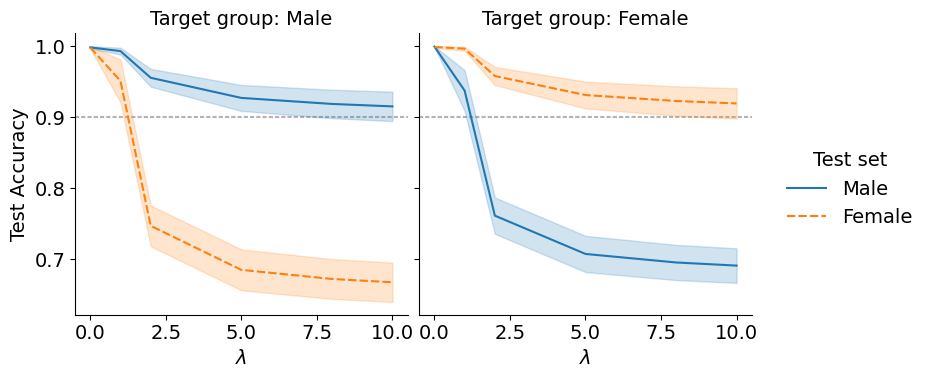

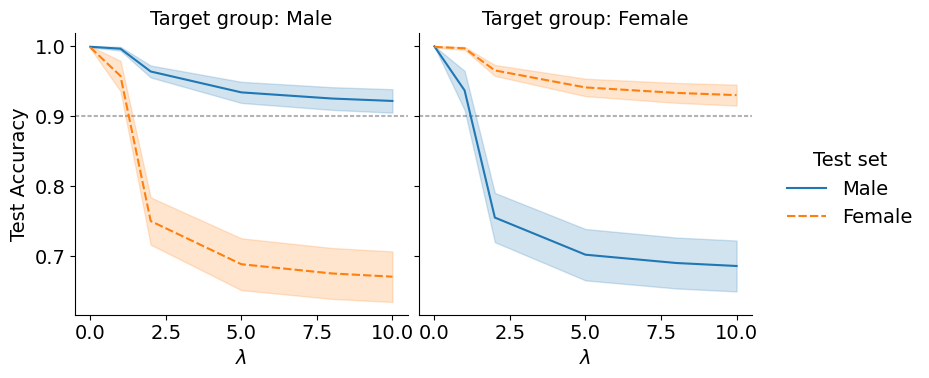

In [ ]:
plot_accuracy(res_df_is, outfile="figures/HCP_in_session_test%s" % test_size)
plot_accuracy(res_df_os, outfile="figures/HCP_out_session_test%s" % test_size)

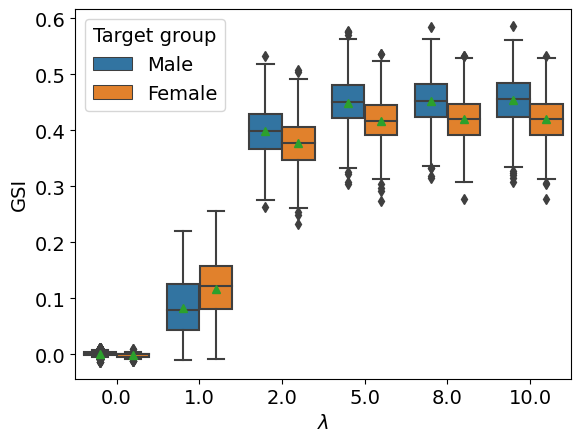

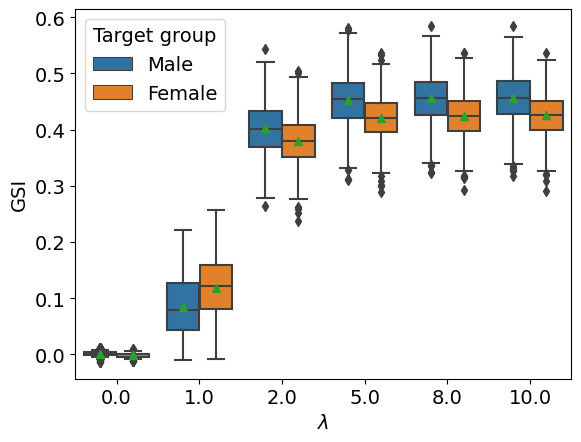

In [ ]:
plot_gsi(res_df_all, x="lambda", y="GSI_is", hue="train_gender", outfile="figures/GSI_box_HCP_in_session_test")
plot_gsi(res_df_all, x="lambda", y="GSI_os", hue="train_gender", outfile="figures/GSI_box_HCP_out_session_test")

In [ ]:
model_root_dir = "/media/shuo/MyDrive/data/HCP/BNA/Models/test_size02"
seed_start = 2023
dataset = "HCP"
test_size = 0.2

In [ ]:
col_names = ["acc_ic_is", "acc_ic_os", "acc_oc_is", "acc_oc_os", "acc_tgt_test_sub", "acc_nt_test_sub",
             "pred_loss", "hsic_loss"]

res_df_all = load_result(dataset=dataset, root_dir=model_root_dir, 
                         lambdas=lambdas, seed_start=seed_start, test_size=test_size)
res_df_all["gap_is"] = res_df_all["acc_ic_is"] - res_df_all["acc_oc_is"]
res_df_all["gap_os"] = res_df_all["acc_ic_os"] - res_df_all["acc_oc_os"]
res_df_all["gap_test_sub"] = res_df_all["acc_tgt_test_sub"] - res_df_all["acc_nt_test_sub"]

res_df_all["GSI_is"] = 2 * (res_df_all["acc_ic_is"] * (res_df_all["acc_ic_is"] - res_df_all["acc_oc_is"])) 
res_df_all["GSI_os"] = 2 * (res_df_all["acc_ic_os"] * (res_df_all["acc_ic_is"] - res_df_all["acc_oc_is"]))
res_df_all["GSI_test_sub"] = 2 * (res_df_all["acc_tgt_test_sub"] * (res_df_all["acc_tgt_test_sub"] - res_df_all["acc_nt_test_sub"]))

res_df_is = reformat_results(res_df_all, ["acc_ic_is", "acc_oc_is"])
res_df_os = reformat_results(res_df_all, ["acc_ic_os", "acc_oc_os"])
res_df_test_sub = reformat_results(res_df_all, ["acc_tgt_test_sub", "acc_nt_test_sub"])

res_df_all.loc[res_df_all["train_gender" ]==0, "train_gender" ] = "Male"
res_df_all.loc[res_df_all["train_gender" ]==1, "train_gender" ] = "Female"

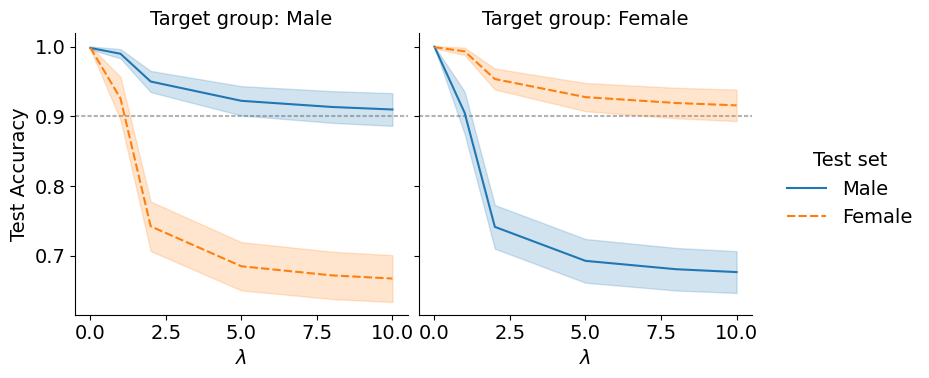

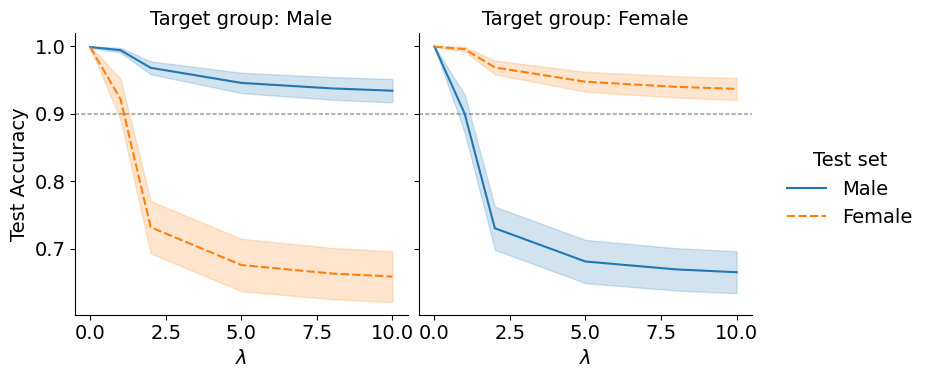

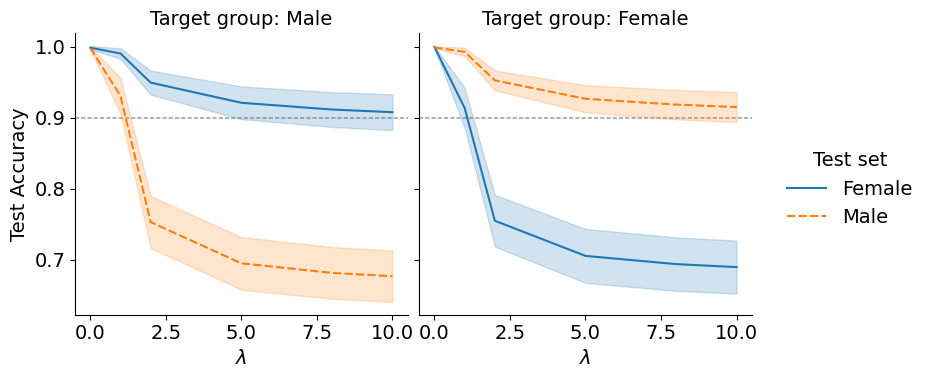

In [ ]:
plot_accuracy(res_df_is, outfile="figures/HCP_in_session_test%s" % test_size)
plot_accuracy(res_df_os, outfile="figures/HCP_out_session_test%s" % test_size)
plot_accuracy(res_df_test_sub, outfile="figures/HCP_test_sub_test%s" % test_size)

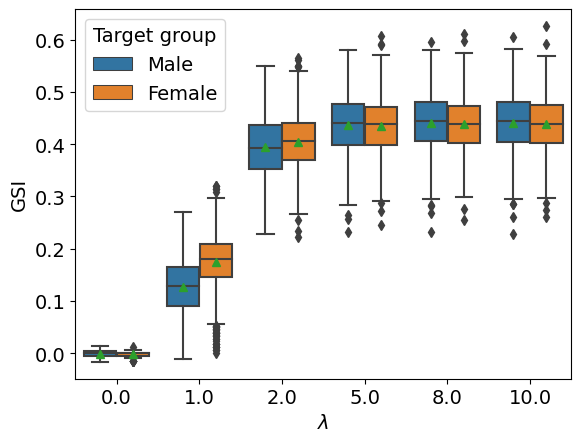

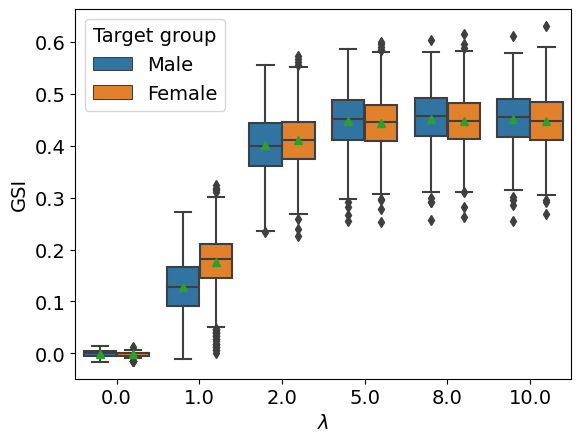

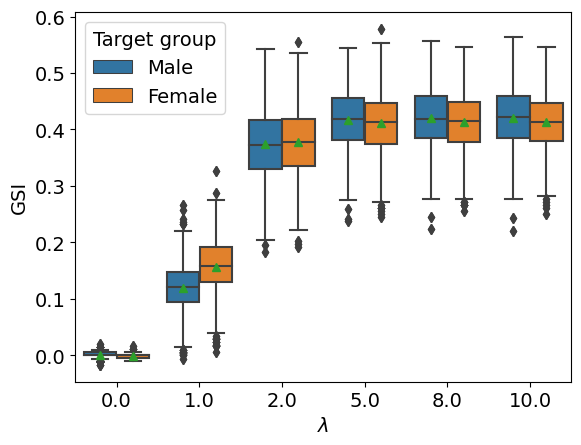

In [ ]:
plot_gsi(res_df_all, x="lambda", y="GSI_is", hue="train_gender", outfile="figures/GSI_box_HCP_in_session_test%s" % test_size)
plot_gsi(res_df_all, x="lambda", y="GSI_os", hue="train_gender", outfile="figures/GSI_box_HCP_out_session_test%s" % test_size)
plot_gsi(res_df_all, x="lambda", y="GSI_test_sub", hue="train_gender", outfile="figures/GSI_box_HCP_test_sub_test%s" % test_size)

In [ ]:
res_df_all

,acc_ic_is,acc_ic_os,acc_oc_is,acc_oc_os,acc_tgt_test_sub,acc_nt_test_sub,train_session,pred_loss,hsic_loss,lambda,...,fold,train_gender,time_used,seed,gap_is,gap_os,gap_test_sub,GSI_is,GSI_os,GSI_test_sub
0,0.997191,0.998596,0.995146,1.000000,1.000000,0.995146,REST1,0.044728,0.693044,0.0,...,0,Male,670.128961,2023,0.002045,-0.001404,0.004854,0.004079,0.004085,0.009709
1,0.997573,1.000000,1.000000,1.000000,1.000000,1.000000,REST1,0.045642,0.692827,0.0,...,0,Female,675.089427,2023,-0.002427,0.000000,0.000000,-0.004843,-0.004854,0.000000
2,0.997191,0.998596,1.000000,1.000000,1.000000,1.000000,REST1,0.043280,0.693042,0.0,...,1,Male,670.895765,2023,-0.002809,-0.001404,0.000000,-0.005602,-0.005610,0.000000
3,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,REST1,0.047788,0.692998,0.0,...,1,Female,675.254037,2023,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.997191,0.998596,0.995146,0.998786,1.000000,1.000000,REST1,0.044997,0.692881,0.0,...,0,Male,671.887912,2023,0.002045,-0.000191,0.000000,0.004079,0.004085,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,0.893204,0.927184,0.654494,0.610955,0.876214,0.648876,REST2,0.103797,0.050019,10.0,...,1,Female,486.105214,1974,0.238710,0.316229,0.227337,0.426433,0.442655,0.398392
11996,0.921348,0.956461,0.750000,0.692961,0.929775,0.706311,REST2,0.061220,0.037012,10.0,...,0,Male,480.485979,1974,0.171348,0.263500,0.223465,0.315743,0.327776,0.415544
11997,0.932039,0.963592,0.716292,0.733146,0.936893,0.733146,REST2,0.064720,0.036043,10.0,...,0,Female,487.283917,1974,0.215747,0.230446,0.203747,0.402169,0.415784,0.381779
11998,0.912921,0.925562,0.643204,0.581311,0.845506,0.621359,REST2,0.097300,0.052252,10.0,...,1,Male,484.225051,1974,0.269717,0.344251,0.224146,0.492462,0.499280,0.379034


In [ ]:
def plot_gaps(gaps, dataset, fontsize=14, color="steelblue", metric="gap", ylabel="Accuracy gap"):
    lambdas = [0.0, 1.0, 2.0, 5.0, 8.0, 10.0]
    plt.figure(figsize=(4, 4))
    plt.plot(lambdas, gaps['mean'], '-', c=color)
    plt.fill_between(lambdas, np.asarray(gaps['mean']) - np.asarray(gaps['std']), 
                    np.asarray(gaps['mean']) + np.asarray(gaps['std']), color=color, alpha=0.2)
    # plt.margins(x=0)
    # plt.legend(loc=5)
    # plt.ylim(bottom=0.6)
    plt.rcParams['text.usetex'] = True
    plt.xlabel(r'$\lambda$', fontsize=fontsize)
    plt.rcParams['text.usetex'] = False
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    plt.ylabel(ylabel, fontsize=fontsize)
    plt.savefig('figures/%s_acc_%s.pdf' % (dataset, metric), format='pdf', bbox_inches='tight')
    plt.savefig('figures/%s_acc_%s.png' % (dataset, metric), format='png', bbox_inches='tight')
    plt.show()

In [ ]:
print(np.mean(res_df_is["Accuracy"]))
print(np.std(res_df_is["Accuracy"]))

0.9995905639794916
0.0010194239783747954


In [ ]:
print(np.mean(res_df_os["Accuracy"]))
print(np.std(res_df_os["Accuracy"]))

0.9995268926584487
0.0008447307486945751


### GSP

In [ ]:
model_root_dir = "/media/shuo/MyDrive/data/brain/brain_networks/gsp/Models"
seed_start = 2023
# col_names = ["acc_ic", "acc_oc", "pred_loss", "code_loss"]
dataset = "gsp"

In [ ]:
lambdas = ["0_group_mix"]

In [ ]:
lambdas = [0.0, 1.0, 2.0, 5.0, 8.0, 10.0]

In [ ]:
res_df_all = load_result(dataset=dataset, root_dir=model_root_dir, 
                         lambdas=lambdas, seed_start=seed_start)
res_df_all["gap"] = res_df_all["acc_ic"] - res_df_all["acc_oc"]
res_df_all["GSI"] = 2 * (res_df_all["acc_ic"] * (res_df_all["acc_ic"] - res_df_all["acc_oc"]))

res_df_reformat = reformat_results(res_df_all, ["acc_ic", "acc_oc"])

res_df_all.loc[res_df_all["train_gender" ]==0, "train_gender" ] = "Male"
res_df_all.loc[res_df_all["train_gender" ]==1, "train_gender" ] = "Female"

In [ ]:
print(np.mean(res_df_reformat["Accuracy"]))
print(np.std(res_df_reformat["Accuracy"]))

0.9997027458148133
0.0005970221778844863


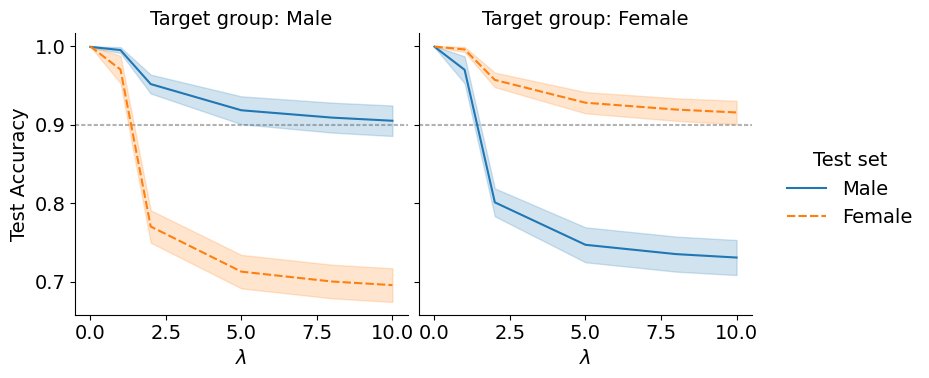

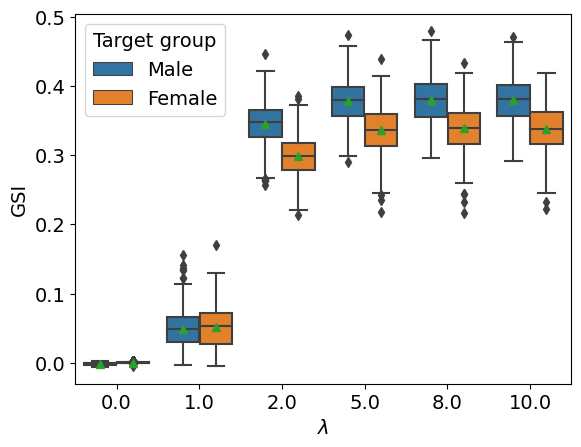

In [ ]:
plot_accuracy(res_df_reformat, outfile="figures/GSP_test")
plot_gsi(res_df_all, x="lambda", y="GSI", hue="train_gender", outfile="figures/GSI_box_GSP_test")

In [ ]:
model_root_dir = "/media/shuo/MyDrive/data/brain/brain_networks/gsp/Models/hold_test_sub/"
seed_start = 2023
# col_names = ["acc_ic", "acc_oc", "pred_loss", "code_loss"]
dataset = "gsp"
test_size = 0.2

In [ ]:
# col_names = ["acc_ic_is", "acc_ic_os", "acc_oc_is", "acc_oc_os", "acc_tgt_test_sub", "acc_nt_test_sub",
#              "pred_loss", "hsic_loss"]

res_df_all = load_result(dataset=dataset, root_dir=model_root_dir, 
                         lambdas=lambdas, seed_start=seed_start, test_size=test_size)

res_df_all["gap"] = res_df_all["acc_ic"] - res_df_all["acc_oc"]
res_df_all["gap_test_sub"] = res_df_all["acc_tgt_test_sub"] - res_df_all["acc_nt_test_sub"]

res_df_all["GSI"] = 2 * (res_df_all["acc_ic"] * (res_df_all["acc_ic"] - res_df_all["acc_oc"]))
res_df_all["GSI_test_sub"] = 2 * (res_df_all["acc_tgt_test_sub"] * (res_df_all["acc_tgt_test_sub"] - res_df_all["acc_nt_test_sub"]))

res_df_reformat = reformat_results(res_df_all, ["acc_ic", "acc_oc"])
res_df_test_sub = reformat_results(res_df_all, ["acc_tgt_test_sub", "acc_nt_test_sub"])

res_df_all.loc[res_df_all["train_gender" ]==0, "train_gender" ] = "Male"
res_df_all.loc[res_df_all["train_gender" ]==1, "train_gender" ] = "Female"

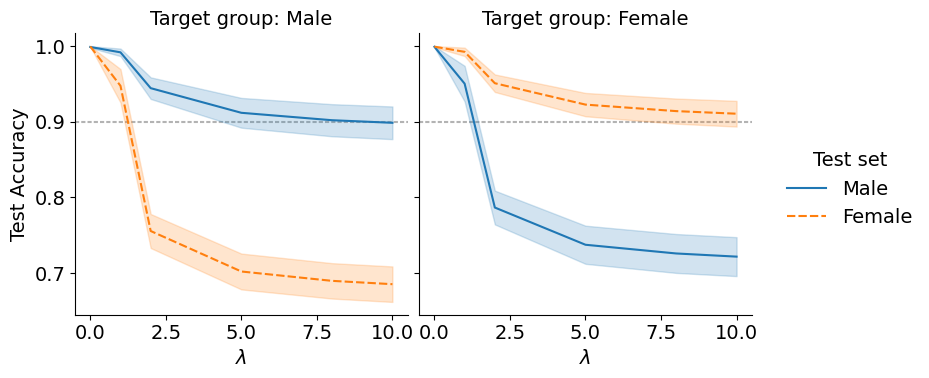

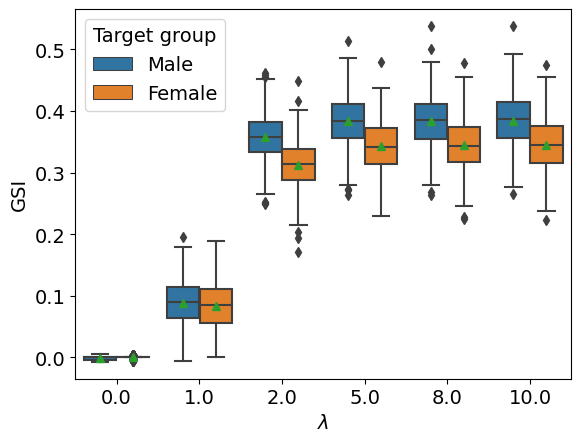

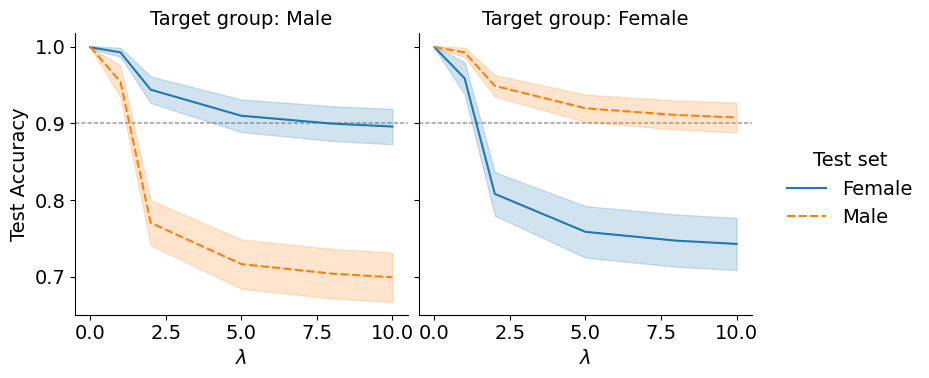

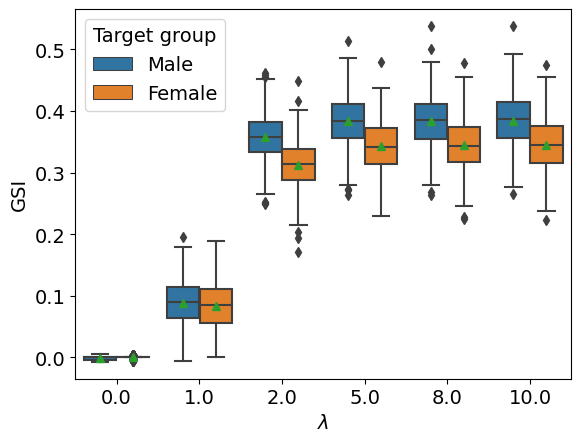

In [ ]:
plot_accuracy(res_df_reformat, outfile="figures/GSP_test%s" % test_size)
plot_gsi(res_df_all, x="lambda", y="GSI", hue="train_gender", 
         outfile="figures/GSI_box_GSP_test%s" % test_size)

plot_accuracy(res_df_test_sub, outfile="figures/GSP_test_sub_test%s" % test_size)
plot_gsi(res_df_all, x="lambda", y="GSI", hue="train_gender", 
         outfile="figures/GSI_box_GSP_test_sub_test%s" % test_size)

### UKB

In [ ]:
model_root_dir = "/media/shuo/MyDrive/data/brain/brain_networks/ukbio/Models"
lambdas = [0.0, 1.0, 2.0, 5.0, 8.0, 10.0]
seed_start = 2023
# col_names = ["acc_ic", "acc_oc", "pred_loss", "code_loss"]
dataset = "ukb"

res_df_all = load_result(dataset=dataset, root_dir=model_root_dir, 
                         lambdas=lambdas, seed_start=seed_start)
res_df_all["gap"] = res_df_all["acc_ic"] - res_df_all["acc_oc"]
res_df_reformat = reformat_results(res_df_all, ["acc_ic", "acc_oc"], male=1)

In [ ]:
g = sns.relplot(
    data=res_df_reformat, x="Lambda", y="Accuracy", col="Target group",
    hue="Test set", style="Test set", kind="line", errorbar=("sd", 1),)
(g.map(plt.axhline, y=0.85, color=".7", dashes=(2, 1), zorder=0)
  .set_axis_labels(r'$\lambda$', "Test Accuracy", fontsize=12)
  .set_titles("Target group: {col_name}")
  .tight_layout(w_pad=0))
plt.savefig('figures/UKB_test.pdf', format='pdf', bbox_inches='tight')
plt.savefig('figures/UKB_test.png', format='png', bbox_inches='tight')
plt.show()

## Plot weight correlation

In [ ]:
def load_weight_plot_corr(dataset, base_dir, sessions, seed_start, fontsize=14):
    control_weights = fetch_weights(base_dir, "mix", "0_group_mix", dataset, sessions=sessions, seed_=seed_start)
    n_control_weights = control_weights.shape[0]

    lambdas = [0.0, 1.0, 2.0, 5.0, 8.0, 10.0]
    corrs = {"mean": [], "sd": []}

    for lambda_ in lambdas:
        for group in [0, 1]:
            weights = fetch_weights(base_dir, group, int(lambda_), dataset, sessions=sessions, seed_=seed_start)
            # n_weights = weights.shape[0]
            corr_matrix = np.corrcoef(control_weights, weights)[n_control_weights:, :n_control_weights]
            corrs["mean"].append(np.mean(corr_matrix))
            corrs["sd"].append(np.std(corr_matrix))
    
    plt.rcParams.update({'font.size': fontsize})
    fig, ax = plt.subplots(2, 1, sharex = True)
    fig.set_size_inches(4, 8.5)
    # .plot(x, y1)
    # .plot(x, y2)
    
    # plt.figure(figsize=(4, 4))
    ax[0].plot(lambdas, corrs['mean'][::2] , '-', c="steelblue", label="Male-specific")
    ax[0].fill_between(lambdas, np.asarray(corrs['mean'][::2]) - np.asarray(corrs['sd'][::2]), 
                    np.asarray(corrs['mean'][::2]) + np.asarray(corrs['sd'][::2]), color="steelblue", alpha=0.2)
    ax[0].set_ylabel("Correlation")
    ax[0].legend(loc='upper right')

    ax[1].plot(lambdas, corrs['mean'][1::2] , '--', color='firebrick', label="Female-specific")
    ax[1].fill_between(lambdas, np.asarray(corrs['mean'][1::2]) - np.asarray(corrs['sd'][1::2]), 
                    np.asarray(corrs['mean'][1::2]) + np.asarray(corrs['sd'][1::2]), color='firebrick', alpha=0.2)

    ax[1].set_ylabel("Correlation")
    ax[1].legend(loc='upper right')
    plt.rcParams['text.usetex'] = True
    plt.xlabel(r'$\lambda$', fontsize=fontsize)
    plt.rcParams['text.usetex'] = False

    plt.savefig('figures/%s_corr.svg' % dataset, format='svg', bbox_inches='tight')
    # plt.savefig('figures/%s_corr.pdf' % dataset, format='pdf', bbox_inches='tight')
    # plt.savefig('figures/%s_corr.png' % dataset, format='png', bbox_inches='tight')
    plt.show()  

### GSP

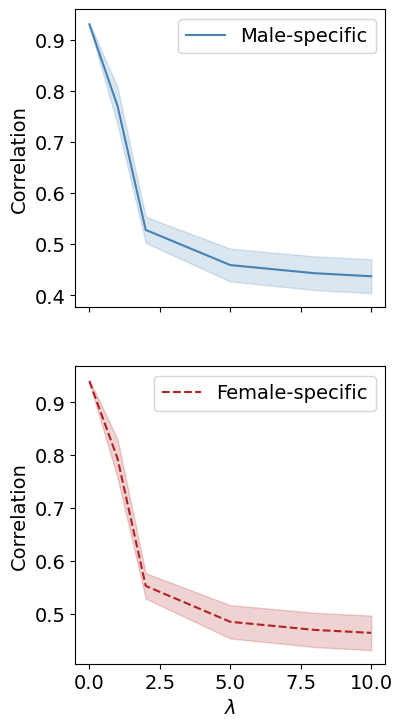

In [ ]:
dataset = "gsp"
base_dir = "/media/shuo/MyDrive/data/brain/brain_networks/gsp/Models"
sessions = [""]
seed_ = 2023

load_weight_plot_corr(dataset, base_dir, sessions, seed_)

### HCP

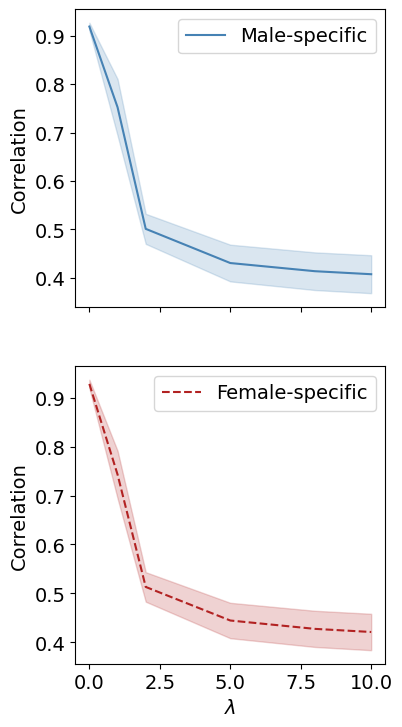

In [ ]:
dataset = "HCP"
base_dir = "/media/shuo/MyDrive/data/HCP/BNA/Models"
sessions = ["REST1_", "REST2_"]
seed_ = 2022

load_weight_plot_corr(dataset, base_dir, sessions, seed_)

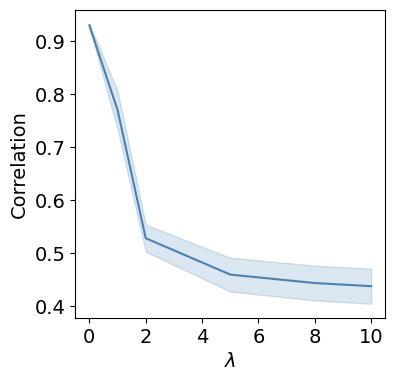

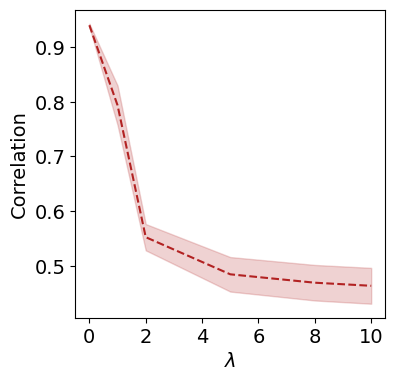

In [ ]:
# plt.figure().set_figheight(4)
fontsize = 14

plt.figure(figsize=(4, 4))
plt.plot(lambdas, corrs['mean'][::2] , '-', c="steelblue")
plt.fill_between(lambdas, np.asarray(corrs['mean'][::2]) - np.asarray(corrs['sd'][::2]), 
                 np.asarray(corrs['mean'][::2]) + np.asarray(corrs['sd'][::2]), color="steelblue", alpha=0.2)
# plt.margins(x=0)
# plt.legend(loc=5)
# plt.ylim(bottom=0.6)
plt.rcParams['text.usetex'] = True
plt.xlabel(r'$\lambda$', fontsize=fontsize)
plt.rcParams['text.usetex'] = False
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.ylabel("Correlation", fontsize=fontsize)
plt.savefig('figures/%s_corr_m.pdf' % dataset, format='pdf', bbox_inches='tight')
plt.savefig('figures/%s_corr_m.png' % dataset, format='png', bbox_inches='tight')
plt.show()

# plt.figure().set_figheight(4)
plt.figure(figsize=(4, 4))
plt.plot(lambdas, corrs['mean'][1::2] , '--', color='firebrick')
plt.fill_between(lambdas, np.asarray(corrs['mean'][1::2]) - np.asarray(corrs['sd'][1::2]), 
                 np.asarray(corrs['mean'][1::2]) + np.asarray(corrs['sd'][1::2]), color='firebrick', alpha=0.2)
plt.rcParams['text.usetex'] = True
plt.xlabel(r'$\lambda$', fontsize=fontsize)
plt.rcParams['text.usetex'] = False
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.ylabel("Correlation", fontsize=fontsize)
plt.savefig('figures/%s_corr_f.pdf' % dataset, format='pdf', bbox_inches='tight')
plt.savefig('figures/%s_corr_f.png' % dataset, format='png', bbox_inches='tight')
plt.show()

### Correlation matrix

In [ ]:
weights_dirs = {
    "Multivariate Control HCP": "./first-order/HCP/HCP_L0Gmix.mat", 
    "Multivariate Control GSP": "./first-order/GSP/GSP_L0_mix_genderGmix.mat",
    "GSDA $\lambda=0$ Male HCP": "./first-order/HCP/HCP_L0G0.mat", 
    "GSDA $\lambda=0$ Female HCP": "./first-order/HCP/HCP_L0G1.mat", 
    "GSDA $\lambda=0$ Male GSP": "./first-order/GSP/GSP_L0G0.mat", 
    "GSDA $\lambda=0$ Female GSP": "./first-order/GSP/GSP_L0G1.mat", 
    "GSDA $\lambda=5$ Male HCP": "./first-order/HCP/HCP_L5G0.mat", 
    "GSDA $\lambda=5$ Female HCP": "./first-order/HCP/HCP_L5G1.mat", 
    "GSDA $\lambda=5$ Male GSP": "./first-order/GSP/GSP_L5G0.mat", 
    "GSDA $\lambda=5$ Female GSP": "./first-order/GSP/GSP_L5G1.mat", 
    }

weights = dict()

for key in weights_dirs:
    # print(key)
    weights[key] = loadmat(weights_dirs[key])["mean"][0][1:]
    
weight_df = pd.DataFrame(weights)

HCP_tval = pd.read_csv("../PostAnalysis/Chord/Univariate/REST1_univariate_L_vs_R_gender_tvalue_uncorrected.csv")
HCP_tval = HCP_tval.rename(columns={'M_F': 'Univariate control HCP ', 'M': 'Univariate Male HCP', 'F': 'Univariate Female HCP'})
GSP_tval = pd.read_csv("../PostAnalysis/Chord/Univariate/GSP_univariate_L_vs_R_gender_tvalue_uncorrected.csv")
GSP_tval = GSP_tval.rename(columns={'M_F': 'Univariate control GSP ', 'M': 'Univariate Male GSP', 'F': 'Univariate Female GSP'})

weight_df = pd.concat((HCP_tval, GSP_tval, weight_df), axis=1)

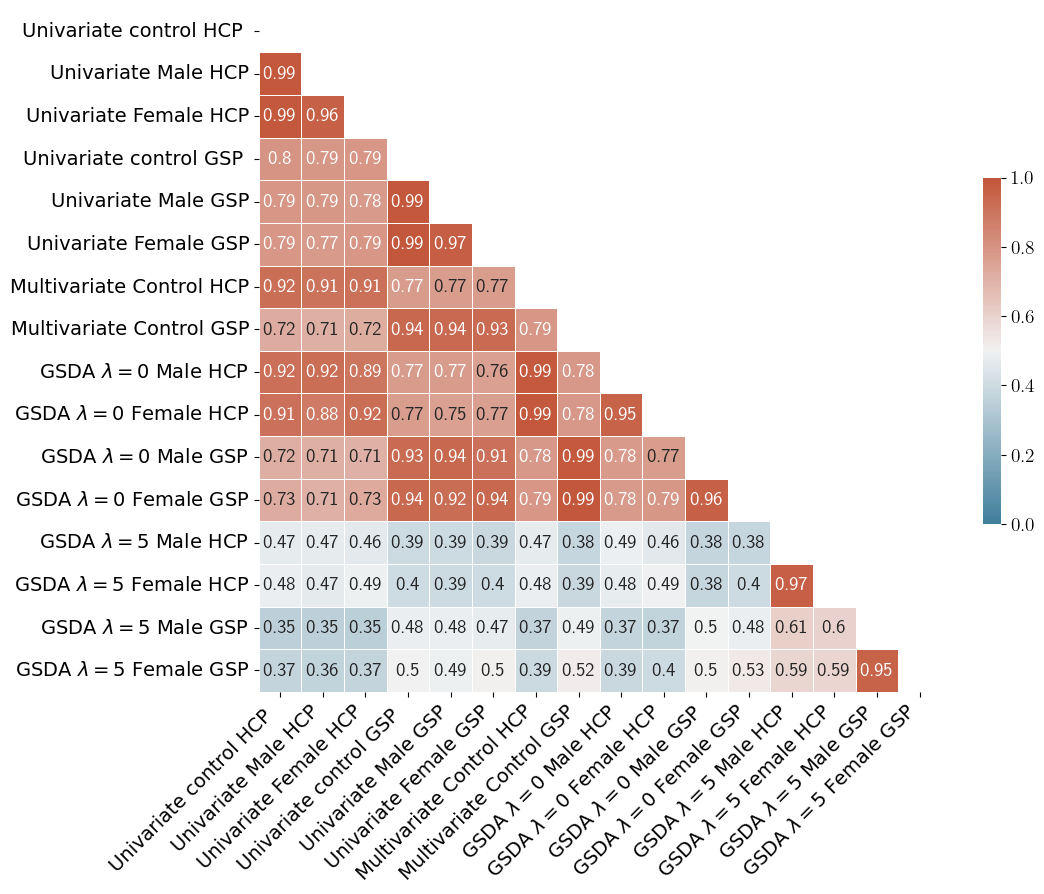

In [ ]:
corr = weight_df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
plt.rcParams.update({'font.size': fontsize})
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
plt.rcParams['text.usetex'] = True
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=0, vmax=1, center=0.5, annot=True, 
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
            # cbar_kws={"shrink": .5, "use_gridspec": False, "location": "top"})  #, annot_kws={"rotation": 45})
plt.rcParams['text.usetex'] = False
# plt.tick_params(axis='x', labelrotation=45)
ax.set_xticklabels(list(weight_df.columns.values), rotation = 45, ha="right")
plt.savefig('figures/corr_annot.svg', format='svg', bbox_inches='tight')
# plt.savefig('figures/corr_annot.pdf', format='pdf', bbox_inches='tight')
# plt.savefig('figures/corr_annot.png', format='png', bbox_inches='tight')
plt.show()

In [ ]:
def load_coef_plot_corr(dataset, sex_label, fontsize=14):
    weights_dirs = dict()
    lambdas = [0.0, 1.0, 2.0, 5.0, 8.0, 10.0]
    sex_dict = {0: "Male", 1: "Female"}
    for lambda_ in lambdas:
        weights_dirs["$\lambda=%s$" % (int(lambda_))] = "./first-order/%s/%s_L%sG%s.mat" % (dataset, dataset, int(lambda_), sex_label)

    weights = dict()

    for key in weights_dirs:
        # print(key)
        weights[key] = loadmat(weights_dirs[key])["mean"][0][1:]
        
    weight_df = pd.DataFrame(weights)
    
    corr = weight_df.corr()

    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool), 1)

    plt.rcParams.update({'font.size': fontsize})
    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    plt.rcParams['text.usetex'] = True
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmin=0, vmax=1, center=0.5, annot=True, annot_kws={"fontsize": "xx-large"},
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
                # cbar_kws={"shrink": .5, "use_gridspec": False, "location": "top"})  #, annot_kws={"rotation": 45})
    plt.rcParams['text.usetex'] = False
    ax.set_xticklabels(list(weight_df.columns.values), fontsize=fontsize+2)
    ax.set_yticklabels(list(weight_df.columns.values), rotation = 45, ha="right", fontsize=fontsize+2)
    # plt.savefig('corr.pdf', format='pdf', bbox_inches='tight')
    # plt.savefig('corr.png', format='png', bbox_inches='tight')
    plt.savefig('figures/corr_annot_%s_%s.svg' % (dataset, sex_dict[sex_label]), format='svg', bbox_inches='tight')
    # plt.savefig('figures/corr_annot_%s_%s.pdf' % (dataset, sex_dict[sex_label]), format='pdf', bbox_inches='tight')
    # plt.savefig('figures/corr_annot_%s_%s.png' % (dataset, sex_dict[sex_label]), format='png', bbox_inches='tight')
    plt.show()

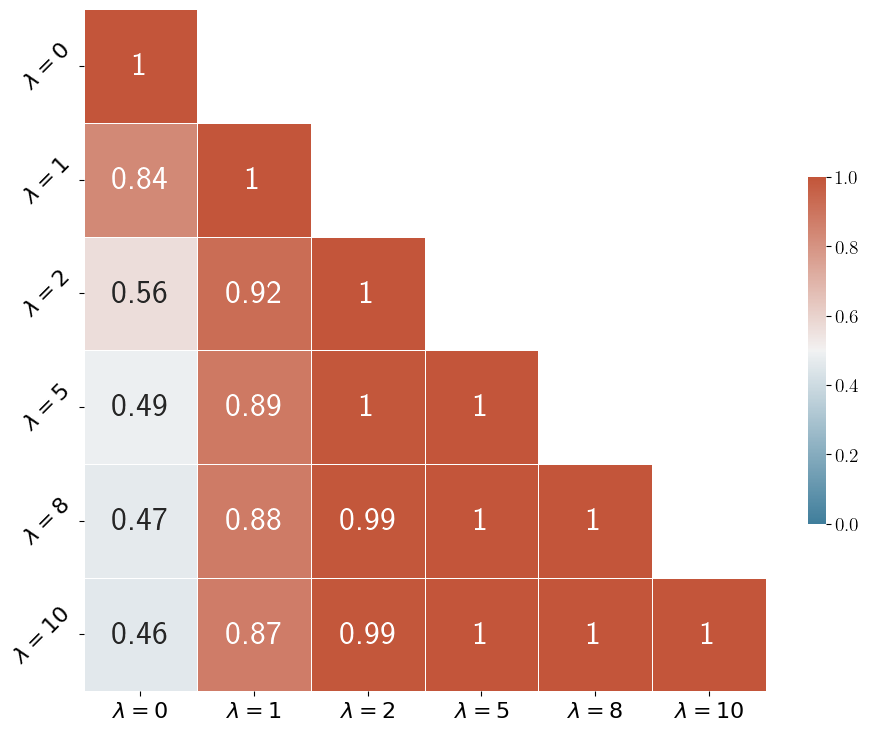

In [ ]:
load_coef_plot_corr("HCP", 0)

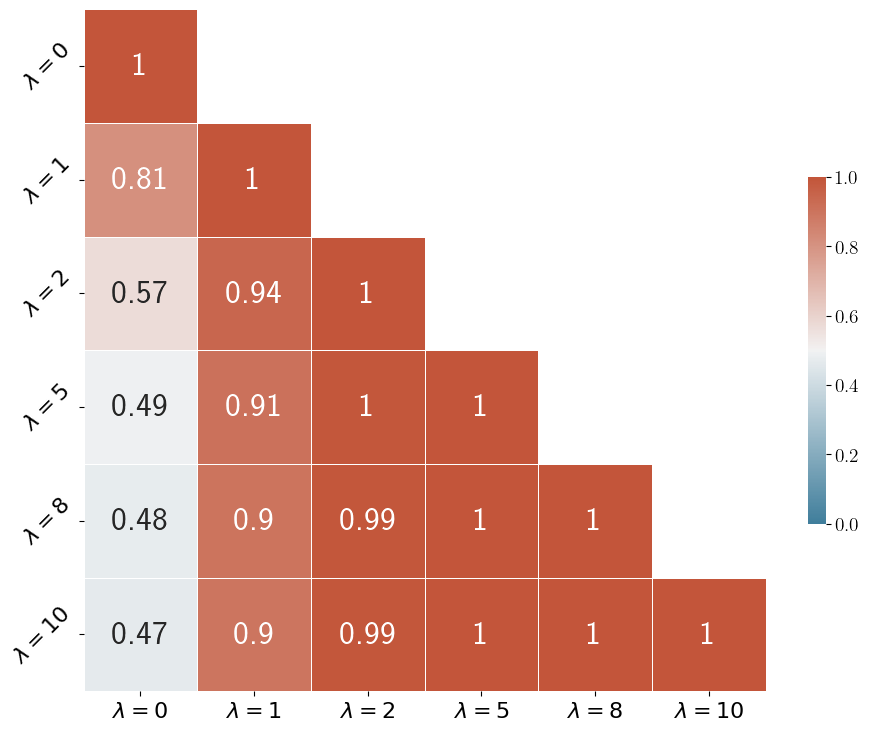

In [ ]:
load_coef_plot_corr("HCP", 1)

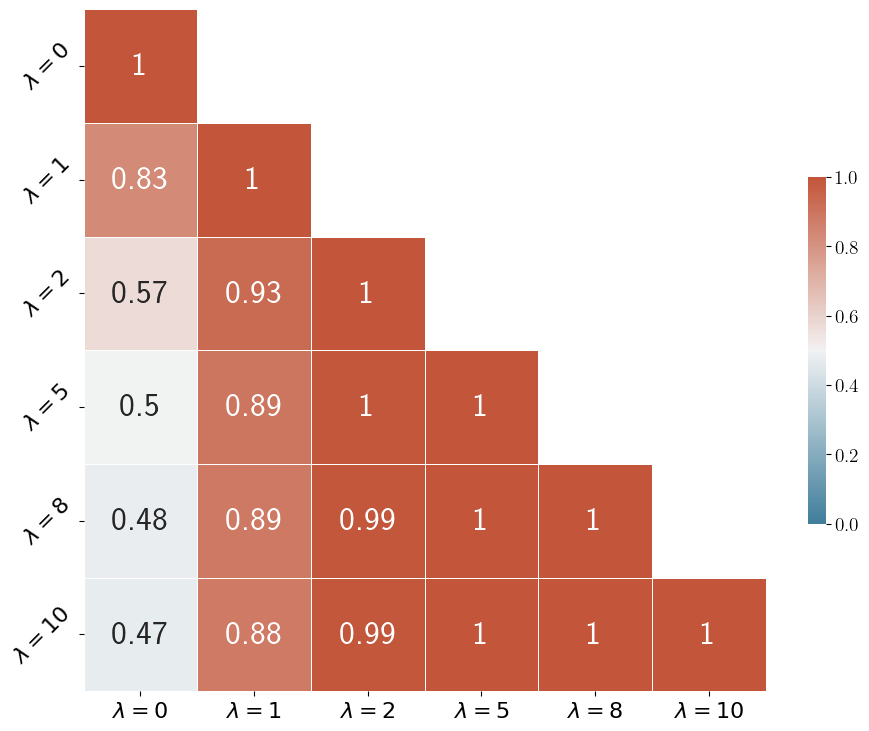

In [ ]:
load_coef_plot_corr("GSP", 0)

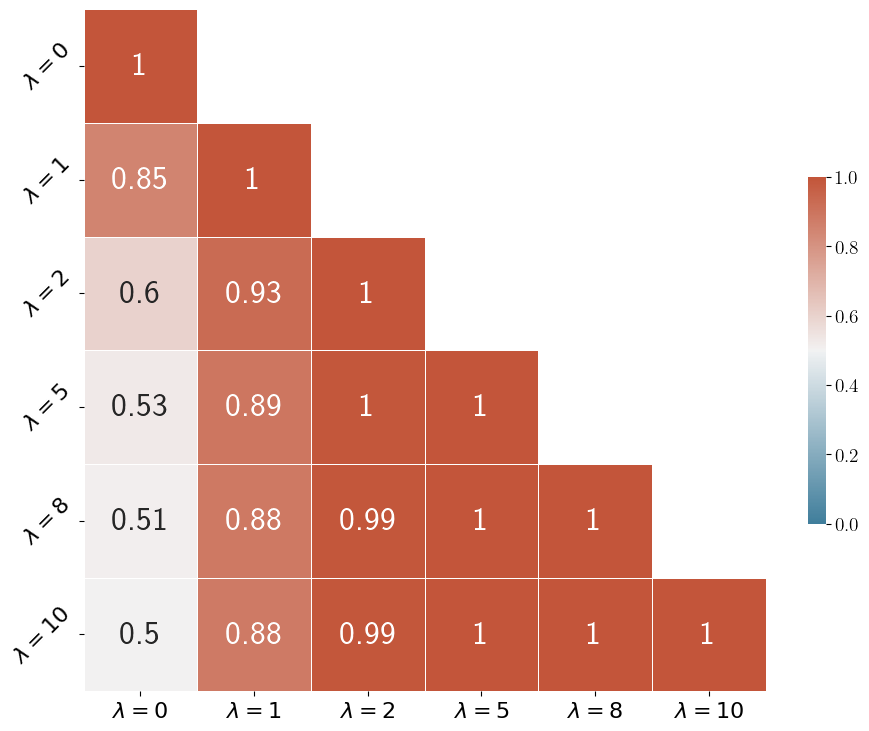

In [ ]:
load_coef_plot_corr("GSP", 1)